In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2],
    c2 = [0.5, 2],
    w = [0.5, 1.2],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = None,
    mask = None))

see one see two 2 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 4
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 100, Accuracy: 0.8271604938271605, Loss: 0.6693923385054977
Checkpoint 200, Accuracy: 0.8333333333333334, Loss: 0.6692913196705006
Checkpoint 300, Accuracy: 0.8271604938271605, Loss: 0.6693824485496238
Checkpoint 400, Accuracy: 0.8395061728395061, Loss: 0.6650565112078631
Checkpoint 500, Accuracy: 0.8333333333333334, Loss: 0.6611073105423538


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 0. 1.] <-> [[0.91054136]
 [0.0571662 ]
 [0.03229244]]
[1. 0. 0.] <-> [[0.89618826]
 [0.06502441]
 [0.0387873 ]]
[1. 0. 0.] <-> [[0.7585632 ]
 [0.16595142]
 [0.0754853 ]]
[0. 0. 1.] <-> [[0.83597034]
 [0.10984413]
 [0.05418556]]
[1. 0. 0.] <-> [[0.90431386]
 [0.06054774]
 [0.03513832]]
[1. 0. 0.] <-> [[0.89154667]
 [0.06796705]
 [0.04048633]]
[1. 0. 0.] <-> [[0.68336326]
 [0.1648482 ]
 [0.15178849]]
[1. 0. 0.] <-> [[0.56346   ]
 [0.35852054]
 [0.0780195 ]]
[1. 0. 0.] <-> [[0.5023487 ]
 [0.41630733]
 [0.08134395]]
[1. 0. 0.] <-> [[0.75237906]
 [0.15575823]
 [0.09186271]]
[1. 0. 0.] <-> [[0.9081379 ]
 [0.05858354]
 [0.03327853]]
[1. 0. 0.] <-> [[0.89408493]
 [0.06633053]
 [0.03958447]]
[0. 1. 0.] <-> [[0.7583042 ]
 [0.16653539]
 [0.07516037]]
[0. 1. 0.] <-> [[0.6527319 ]
 [0.17083955]
 [0.17642857]]
[0. 0. 1.] <-> [[0.4745013 ]
 [0.20729499]
 [0.31820378]]
[1. 0. 0.] <-> [[0.90638554]
 [0.05950534]
 [0.03410905]]
[1. 0. 0.] <-> [[0.882325  ]
 [0.07429266]
 [0.04338237]]
[1. 0. 0.] <->

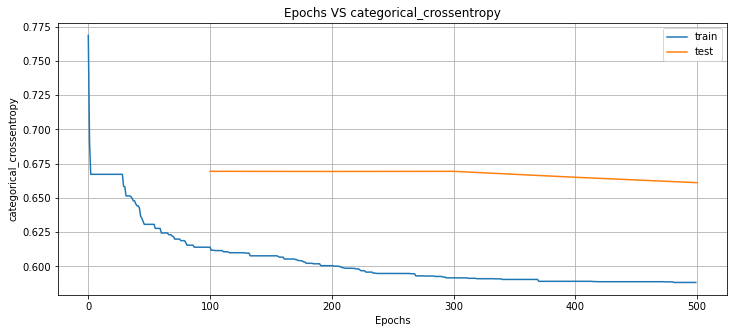

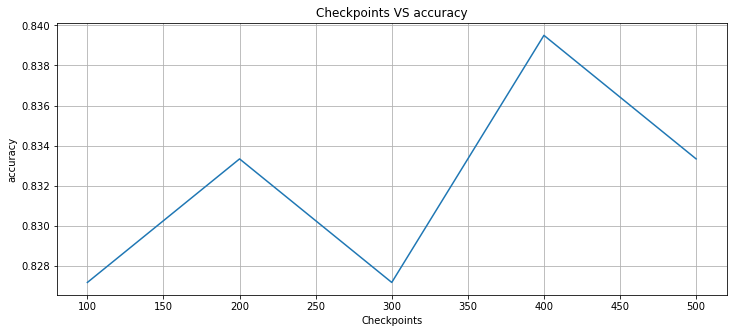

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8271604938271605, 'mean_square_error': 3.030814937395981, 'categorical_crossentropy': 0.6693923385054977, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 21, 'tn_hit': 9, 'fn_hit': 1}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 3, 'fp_hit': 7, 'tn_hit': 87, 'fn_hit': 11}}, 'checkpoint': 100} 


{'accuracy': 0.8333333333333334, 'mean_square_error': 2.944069523234071, 'categorical_crossentropy': 0.6692913196705006, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 23, 'tn_hit': 7, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 3, 'fp_hit': 4, 'tn_hit': 90, 'fn_hit': 11}}, 'checkpoint': 200} 


{'accuracy': 0.8271604938271605, 'mean_square_error': 2.975461189838722, 'categorical_crossentropy': 0.6693824485496238, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 22, 'tn_hit': 8, 'fn_hit': 1}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 3, 'fp_hit': 6, 'tn_hit': 88, 'fn_hit':

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[[ 2.9974325 ]
 [ 0.48135647]
 [-0.72548014]
 [ 1.6577529 ]
 [ 3.        ]]
 bias: [-1.9810282]

Neuron 1: weights:
[[-1.0914446 ]
 [-2.7570503 ]
 [-0.24448688]
 [-1.904329  ]
 [-2.3674662 ]]
 bias: [-1.2175076]

Neuron 2: weights:
[[-0.83153623]
 [ 1.609367  ]
 [ 1.984073  ]
 [ 1.1578983 ]
 [-1.1632195 ]]
 bias: [-1.6801786]

Neuron 3: weights:
[[-1.9118967 ]
 [ 0.9282945 ]
 [ 0.58599615]
 [ 1.249272  ]
 [ 0.66924757]]
 bias: [-3.]

$
Layer 2
Neuron 0: weights:
[[ 0.41283292]
 [ 2.6449199 ]
 [-0.5471933 ]
 [-3.        ]]
 bias: [0.34857494]

Neuron 1: weights:
[[-3.        ]
 [-0.95120066]
 [-0.3157039 ]
 [ 3.        ]]
 bias: [1.1732033]

Neuron 2: weights:
[[-2.5682626]
 [ 1.1275889]
 [ 3.       ]
 [ 2.1459956]]
 bias: [-1.4764177]

$

